In [3]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from tqdm.notebook import tqdm
from glob import glob
from matplotlib import pyplot as plt

import Regressions as reg
import DataBuild as db

No w2v was able to load


In [11]:
ON_RHINO = False
BETAS_ORDER = ['output_pos', 'total_recalls', 'lag',
             'sem', 'session', 'lag_sem', 'irt-1', 'irt-2']

In [12]:
def abbrv(beta):
    if beta == 'session': return 'SESS'
    if beta == 'lag': return 'LAG'
    if beta == 'sem': return 'SIM'
    if beta == 'total_recalls': return 'R'
    if beta == 'lag_sem': return 'SIMxLAG'
    if beta == 'output_pos': return 'OP'
    if beta == 'irt-1': return 'IRT₋₁'
    if beta == 'irt-2': return 'IRT₋₂'
    return beta

In [13]:
sd = 3

In [23]:
# get behavioral data for ltpFR2 all subjects
if ON_RHINO:
    path = '/data/eeg/scalp/ltp/ltpFR2/behavioral/data/'
    files = [f for f in glob(path+'beh_data_LTP*.json') if 'incomplete' not in f]
    subjs = ['LTP'+file.split('LTP')[1].replace('.json', '') for file in files]
else:
    path = './data/*'
    subjs = [f.split('/')[-1] for f in glob(path)]

In [33]:
def get_betas(subjs, **kwargs):
    """Returns all betas, pvals and r^2s for the subjects given. """
    
    r2s = []
    betas = pd.DataFrame()
    pvals = pd.DataFrame()

    for subject in tqdm(subjs):
        model = reg.get_model(subject=subject, **kwargs)
        betas[subject] = model.params
        pvals[subject] = model.pvalues
        r2s.append(model.rsquared)
    betas = betas.transpose()
    pvals = pvals.transpose()
    return betas, pvals, r2s

In [34]:
def relabel_betas(betas, pvals):
    betas = betas.copy()
    pvals = pvals.copy()
    for i in [betas, pvals]:
        i.pop('const')
        for key in order:
            i[abbrv(key)] = i.pop(key)
    return betas, pvals

In [61]:
rbetas, rpvals, r2s = get_betas(subjs)
betas, pvals = relabel_betas(rbetas, rpvals)

  0%|          | 0/98 [00:00<?, ?it/s]

In [65]:
results = pd.DataFrame()
results['mean'] = betas.mean().round(sd)
results['CI'] = (1.96 * betas.sem()).round(sd)
r2 = pd.Series([np.mean(r2s), scipy.stats.sem(r2s)], name='R^2', index=['mean', 'CI']).round(sd)
results = results.append(r2)

results

/var/folders/y5/cmj8rhp533v0zw59s7_t7lrc0000gn/T/ipykernel_43992/3960883720.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(r2)


,mean,CI
OP,0.148,0.016
R,-0.090,0.015
LAG,0.400,0.020
SIM,-0.138,0.012
SESS,-0.094,0.014
SIMxLAG,-0.095,0.010
IRT₋₁,0.085,0.013
IRT₋₂,0.076,0.008
R^2,0.255,0.006


NameError: name 'order' is not defined

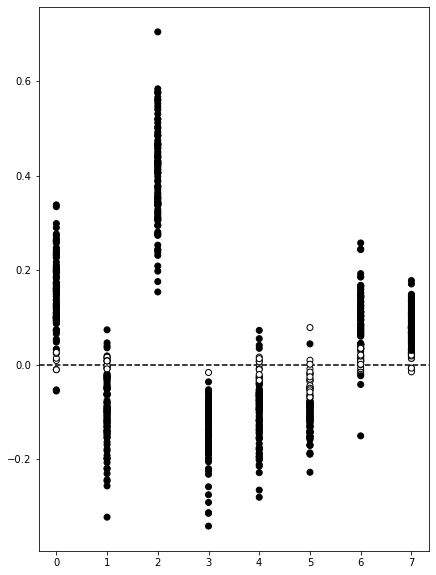

In [66]:
fig, axes = plt.subplots(figsize=(7,10))

plt.axhline(0, color='k', linestyle='--', zorder=1)

for i, col in enumerate(betas.columns):
    colors = [(0,0,0) if p < 0.05
              else (1,1,1)
              for p in pvals[col]]
    plt.scatter([i]*len(betas), betas[col], c=colors, edgecolor='k', zorder=10)
plt.xticks(range(len(order)), [abbrv(i) for i in order], rotation=60, ha='right', fontsize=20)
plt.yticks(np.arange(-.2,.7, .2), fontsize=16)
plt.ylim((-1, 1))
plt.ylabel('Z(Beta Coeficient)', fontsize=20)